# OpenAi-GYM Bipedal_Walker_v2 Deep Q Network Learning


In [1]:
from itertools import count
import numpy as np
import random
import math

import gym


import torch, torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Check for GPU
use_gpu = torch.cuda.is_available()

if use_gpu:
    print("Using GPU")
    LongTensor = torch.cuda.LongTensor
    FloatTensor = torch.cuda.FloatTensor

else:
    print("Using CPU")
    LongTensor = torch.LongTensor
    FloatTensor = torch.FloatTensor

Using GPU


# Setting and Running Model with Environment

In [2]:
NUM_EPISODES = 2000
SCREEN_WIDTH = 400
SCREEN_LENGTH =600
WINDOW_MAX_Y = 300
WINDOW_MIN_Y = 200
BUFFER_SIZE = 65536
GAMMA = 0.999
START_EXPLORE_RATIO = 0.7
END_EXPLORE_RATIO = 0.05
NUM_FEATURES = 24
FALL_TIME = 30  


class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.hidden1 = nn.Linear(NUM_FEATURES, 400)
        self.hidden2 = nn.Linear(400, 300)
        self.output = nn.Linear(300, 16)

        # Weights initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                n = len(m.weight.data[1])
                # "Xavier" initialization
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()

        self.optimizer = optim.RMSprop(self.parameters(), lr=0.0001)

    
    def forward(self,x):
        x = F.tanh(self.hidden1(x))
        x = F.tanh(self.hidden2(x))
        return self.output(x)

    def update(self,transition_buffer):
        
        transition_batch = transition_buffer.get_batch()
        if transition_batch is None:
            return

        states, actions, rewards, next_states = transition_batch
        non_final_mask = [i for i, state in enumerate(next_states) if state is not None]
        non_final_mask = LongTensor(non_final_mask)
     
        non_final_next_states = Variable(torch.cat([s for s in next_states if s is not None]).view(-1, NUM_FEATURES),
                                         volatile=True)

        states = Variable(torch.cat(list(states)).view(-1, NUM_FEATURES))
        actions = Variable(torch.cat(list(actions)).view(-1, 1).type(LongTensor))
        rewards = Variable(torch.cat(list(rewards)))

        q_values = self.forward(states).gather(1, actions)

        next_state_values = Variable(torch.zeros(32).type(FloatTensor))

        next_state_values[non_final_mask] = self.forward(non_final_next_states).max(1)[0]

        next_state_values.volatile = False

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + rewards

        # Compute Huber loss
        loss = F.smooth_l1_loss(q_values, expected_state_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

class TransitionBuffer:
    def __init__(self):
        self.buffer = []
        self.batch_size = 32

    def push(self,transition):
        self.buffer.append(transition)
        if len(self.buffer) > BUFFER_SIZE:
            self.buffer.pop(0)

    def get_batch(self):
        if len(self.buffer) >= self.batch_size:
            batch = random.sample(self.buffer, self.batch_size)
            # Transposing list of lists
            return list(zip(*batch))   
        

## Execute and Train Model

In [3]:
def get_action(model,state, explore_ratio, randomization=True):
    chance = random.random()
    if chance < explore_ratio and randomization:
        return LongTensor([random.randint(0, 15)])
    else:
        q_values = model(state)

        return q_values.max(0)[1].data


def get_action_vec(action_ind):
    action_vec = np.array([int(bit) for bit in '{0:04b}'.format(action_ind)])
    return action_vec*2 - 1


def get_decay_ratio():
    return math.pow(END_EXPLORE_RATIO/START_EXPLORE_RATIO, 1.5/NUM_EPISODES)

In [4]:
env = gym.make('BipedalWalker-v2').unwrapped
env.reset()
model = DQN()

if use_gpu:
    model.cuda()

transition_buffer = TransitionBuffer()

reward_his = np.zeros(NUM_EPISODES)
steps_his = np.zeros(NUM_EPISODES)
distance_his = np.zeros(NUM_EPISODES)
velocity_his = np.zeros(NUM_EPISODES)

min_max_states = np.zeros((NUM_FEATURES, 2))

explore_ratio = START_EXPLORE_RATIO
explore_decay_ratio = get_decay_ratio()

for episode in range(NUM_EPISODES):
    env.reset()
    action_vec = env.action_space.sample()

    current_state = FloatTensor(np.zeros(NUM_FEATURES))

    for i in count():
        env.render(mode='rgb_array')

        if i < FALL_TIME:
               action_ind = 8

        else:
            randomization = bool(np.mod(episode, 50))
            action_ind = get_action(model, Variable(current_state, volatile=True), explore_ratio, randomization)
            action_vec = get_action_vec(int(action_ind.cpu().numpy()))

        obs, reward, done, info = env.step(action_vec)

        distance_his[episode] += obs[2]

        if done is False:
            next_state = FloatTensor(obs[:NUM_FEATURES])
            reward_his[episode] += reward
        else:
            next_state = None

        if i >= FALL_TIME:
            transition_buffer.push([current_state, action_ind, FloatTensor([reward]), next_state])

        current_state = next_state
        
        #update model
        model.update(transition_buffer)

        if done is True:
            steps_his[episode] = i
            velocity_his[episode] = distance_his[episode]/i
            print("Episode", episode, ", steps = ", i,
                    ", total reward:", reward_his[episode],
                    ", steps_avg:", np.mean(steps_his[:episode+1]),
                    ", reward_avg:", np.mean(reward_his[:episode+1]),
                    ", distance traveled:", distance_his[episode],
                    ", average speed:", velocity_his[episode],
                    ", explore ratio:", explore_ratio)
            break

    if explore_ratio > END_EXPLORE_RATIO:
           explore_ratio = explore_ratio*explore_decay_ratio


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 0 , steps =  90 , total reward: -9.671067846184602 , steps_avg: 90.0 , reward_avg: -9.671067846184602 , distance traveled: 12.897258191630248 , average speed: 0.14330286879589166 , explore ratio: 0.7
Episode 1 , steps =  108 , total reward: -9.467656287262844 , steps_avg: 99.0 , reward_avg: -9.569362066723723 , distance traveled: 10.128399570914915 , average speed: 0.09378147750847143 , explore ratio: 0.6986158651580259
Episode 2 , steps =  9943 , total reward: -866.7401947937425 , steps_avg: 3380.3333333333335 , reward_avg: -295.29297297573 , distance traveled: 349.5914554775514 , average speed: 0.03515955501131966 , explore ratio: 0.6972344672149957
Episode 3 , steps =  66 , total reward: -5.711673735859495 , steps_avg: 2551.75 , reward_avg: -222.89764816576235 , distance traveled:

Episode 35 , steps =  86 , total reward: -22.287586747375002 , steps_avg: 612.3055555555555 , reward_avg: -55.82558118845396 , distance traveled: -3.937477956209332 , average speed: -0.04578462739778293 , explore ratio: 0.6531488688813176
Episode 36 , steps =  128 , total reward: -25.657160370080426 , steps_avg: 599.2162162162163 , reward_avg: -55.01021846363305 , distance traveled: -7.670378421633502 , average speed: -0.05992483141901173 , explore ratio: 0.6518573744435825
Episode 37 , steps =  360 , total reward: -36.72592477571213 , steps_avg: 592.921052631579 , reward_avg: -54.529052840266715 , distance traveled: 11.299925496848308 , average speed: 0.03138868193568974 , explore ratio: 0.6505684337236324
Episode 38 , steps =  839 , total reward: -69.26302309944515 , steps_avg: 599.2307692307693 , reward_avg: -54.90684694947642 , distance traveled: 40.531470759892805 , average speed: 0.048309261930742316 , explore ratio: 0.6492820416719104
Episode 39 , steps =  181 , total reward: -3

Episode 70 , steps =  219 , total reward: -40.26434059953809 , steps_avg: 449.90140845070425 , reward_avg: -43.51932479676246 , distance traveled: -18.88696408278308 , average speed: -0.08624184512686338 , explore ratio: 0.6094334927442066
Episode 71 , steps =  1945 , total reward: -162.35480136068625 , steps_avg: 470.6666666666667 , reward_avg: -45.16981752681696 , distance traveled: 79.52195528855368 , average speed: 0.04088532405581166 , explore ratio: 0.608228438271102
Episode 72 , steps =  56 , total reward: -2.609441003549225 , steps_avg: 464.986301369863 , reward_avg: -44.58679867033385 , distance traveled: 7.413412904441355 , average speed: 0.13238237329359562 , explore ratio: 0.6070257665949726
Episode 73 , steps =  70 , total reward: -15.346379991431412 , steps_avg: 459.64864864864865 , reward_avg: -44.19165787737571 , distance traveled: -7.605756487213076 , average speed: -0.10865366410304393 , explore ratio: 0.6058254730042296
Episode 74 , steps =  2247 , total reward: -192

Episode 105 , steps =  43 , total reward: -22.033982840370385 , steps_avg: 697.3679245283018 , reward_avg: -61.966054154644155 , distance traveled: -3.736414952427149 , average speed: -0.08689337098667789 , explore ratio: 0.5686439949203844
Episode 106 , steps =  59 , total reward: -13.295043768602115 , steps_avg: 691.4018691588785 , reward_avg: -61.51118489869984 , distance traveled: -4.521709041427821 , average speed: -0.0766391362953868 , explore ratio: 0.5675195949688864
Episode 107 , steps =  67 , total reward: -14.55995205401692 , steps_avg: 685.6203703703703 , reward_avg: -61.076451261249076 , distance traveled: -3.2709414418274534 , average speed: -0.04882002151981274 , explore ratio: 0.5663974183333157
Episode 108 , steps =  63 , total reward: -0.10174367583729278 , steps_avg: 679.9082568807339 , reward_avg: -60.51705027422695 , distance traveled: 9.916023159474133 , average speed: 0.15739719300752592 , explore ratio: 0.565277460617431
Episode 109 , steps =  69 , total reward:

Episode 140 , steps =  42 , total reward: -16.07897767654248 , steps_avg: 642.4822695035461 , reward_avg: -54.60892428613734 , distance traveled: -2.1034061729907987 , average speed: -0.05008109935692378 , explore ratio: 0.5305845458262894
Episode 141 , steps =  89 , total reward: -16.271670243953054 , steps_avg: 638.5845070422536 , reward_avg: -54.33894362386844 , distance traveled: -6.702624813686125 , average speed: -0.07531039116501263 , explore ratio: 0.5295354021741592
Episode 142 , steps =  39 , total reward: -14.941031650880982 , steps_avg: 634.3916083916084 , reward_avg: -54.06343374993146 , distance traveled: -0.3792657054215669 , average speed: -0.009724761677476074 , explore ratio: 0.5284883330310048
Episode 143 , steps =  1450 , total reward: -69.60750846852278 , steps_avg: 640.0555555555555 , reward_avg: -54.17137871325501 , distance traveled: 133.76351595777535 , average speed: 0.09225070066053473 , explore ratio: 0.5274433342948263
Episode 144 , steps =  72 , total rewa

Episode 175 , steps =  62 , total reward: -6.898491012602425 , steps_avg: 575.375 , reward_avg: -48.59235868605976 , distance traveled: 5.398861061520873 , average speed: 0.0870784042180786 , explore ratio: 0.49507242278906893
Episode 176 , steps =  61 , total reward: -6.342061378444852 , steps_avg: 572.4689265536723 , reward_avg: -48.35365644138396 , distance traveled: 3.622306054774671 , average speed: 0.05938206647171592 , explore ratio: 0.4940934985180934
Episode 177 , steps =  73 , total reward: -9.470619373393564 , steps_avg: 569.6629213483146 , reward_avg: -48.13521241291211 , distance traveled: 3.5896953993290657 , average speed: 0.04917390957985021 , explore ratio: 0.4931165099088195
Episode 178 , steps =  135 , total reward: -23.876489426841303 , steps_avg: 567.2346368715084 , reward_avg: -47.99968882081115 , distance traveled: -4.796369927627965 , average speed: -0.03552866613057752 , explore ratio: 0.49214145313379454
Episode 179 , steps =  76 , total reward: -3.36743789664

Episode 210 , steps =  49 , total reward: -6.062110830941553 , steps_avg: 505.9194312796209 , reward_avg: -42.975145170501804 , distance traveled: 0.9565123033791316 , average speed: 0.01952065925263534 , explore ratio: 0.46193713279859105
Episode 211 , steps =  333 , total reward: -4.435631587071368 , steps_avg: 505.10377358490564 , reward_avg: -42.7933550120894 , distance traveled: 48.26744876861573 , average speed: 0.14494729359944664 , explore ratio: 0.4610237281124366
Episode 212 , steps =  82 , total reward: -12.430152137070895 , steps_avg: 503.11737089201876 , reward_avg: -42.65080476384987 , distance traveled: -0.3197669030190438 , average speed: -0.003899596378281022 , explore ratio: 0.46011212953378344
Episode 213 , steps =  233 , total reward: -14.008168265335893 , steps_avg: 501.8551401869159 , reward_avg: -42.51696066806242 , distance traveled: 19.363130719810727 , average speed: 0.08310356532107607 , explore ratio: 0.45920233349135114
Episode 214 , steps =  364 , total re

Episode 245 , steps =  64 , total reward: -10.57609550990971 , steps_avg: 471.7560975609756 , reward_avg: -40.065498715456485 , distance traveled: 3.1351519225537774 , average speed: 0.04898674878990277 , explore ratio: 0.43101959397382683
Episode 246 , steps =  40 , total reward: -17.405019578446336 , steps_avg: 470.0080971659919 , reward_avg: -39.97375588494228 , distance traveled: -2.8309115785360337 , average speed: -0.07077278946340085 , explore ratio: 0.4301673236344087
Episode 247 , steps =  59 , total reward: -0.7462621024704187 , steps_avg: 468.3508064516129 , reward_avg: -39.81558050678715 , distance traveled: 10.007517490983009 , average speed: 0.16961894052513574 , explore ratio: 0.4293167385193785
Episode 248 , steps =  50 , total reward: -13.772383856972056 , steps_avg: 466.6706827309237 , reward_avg: -39.71098935558307 , distance traveled: -0.4504053195565938 , average speed: -0.009008106391131875 , explore ratio: 0.4284678352964823
Episode 249 , steps =  84 , total rewa

Episode 280 , steps =  54 , total reward: -9.160526830344772 , steps_avg: 510.5338078291815 , reward_avg: -40.84388470662431 , distance traveled: 2.1243235981464386 , average speed: 0.03933932589160071 , explore ratio: 0.40217137181384244
Episode 281 , steps =  395 , total reward: -8.020192283007047 , steps_avg: 510.1241134751773 , reward_avg: -40.727488634200135 , distance traveled: 56.4102481484553 , average speed: 0.14281075480621597 , explore ratio: 0.40137614408788236
Episode 282 , steps =  77 , total reward: -4.786271391255786 , steps_avg: 508.59363957597174 , reward_avg: -40.600487866557216 , distance traveled: 15.8030546683073 , average speed: 0.20523447621178312 , explore ratio: 0.4005824887939263
Episode 283 , steps =  71 , total reward: -22.83573296022105 , steps_avg: 507.05281690140845 , reward_avg: -40.53793591266167 , distance traveled: -5.60004294913262 , average speed: -0.07887384435398057 , explore ratio: 0.3997904028227486
Episode 284 , steps =  221 , total reward: -4

Episode 315 , steps =  211 , total reward: 2.7684231660160967 , steps_avg: 501.1613924050633 , reward_avg: -38.299290519412516 , distance traveled: 43.49752183977052 , average speed: 0.2061493926055475 , explore ratio: 0.37525396656665555
Episode 316 , steps =  41 , total reward: -22.244672119469683 , steps_avg: 499.7097791798107 , reward_avg: -38.24864503550103 , distance traveled: -3.358398621082306 , average speed: -0.08191216148981234 , explore ratio: 0.37451196358135
Episode 317 , steps =  711 , total reward: -35.93263330464606 , steps_avg: 500.37421383647796 , reward_avg: -38.24136197974362 , distance traveled: 72.9660227395641 , average speed: 0.10262450455634894 , explore ratio: 0.37377142778487993
Episode 318 , steps =  96 , total reward: -24.027114465247216 , steps_avg: 499.1065830721003 , reward_avg: -38.1968032101057 , distance traveled: -2.2205740296095606 , average speed: -0.02313097947509959 , explore ratio: 0.3730323562761207
Episode 319 , steps =  93 , total reward: -2

Episode 350 , steps =  790 , total reward: 2.188421097298418 , steps_avg: 480.15669515669515 , reward_avg: -35.54075662334272 , distance traveled: 130.6654379166638 , average speed: 0.16539928850210606 , explore ratio: 0.3501381482946268
Episode 351 , steps =  46 , total reward: -28.230464639935022 , steps_avg: 478.92329545454544 , reward_avg: -35.519988748389856 , distance traveled: -5.592352543249726 , average speed: -0.12157288137499404 , explore ratio: 0.3494458077081141
Episode 352 , steps =  90 , total reward: -25.683565785198795 , steps_avg: 477.8215297450425 , reward_avg: -35.49212352753096 , distance traveled: -3.2652476106776147 , average speed: -0.03628052900752905 , explore ratio: 0.3487548361112133
Episode 353 , steps =  231 , total reward: -35.667331214306195 , steps_avg: 477.1242937853107 , reward_avg: -35.49261846449925 , distance traveled: -2.927023176155632 , average speed: -0.012671096000673732 , explore ratio: 0.34806523079697255
Episode 354 , steps =  65 , total re

Episode 385 , steps =  61 , total reward: -0.6365658427414776 , steps_avg: 463.8523316062176 , reward_avg: -33.948579573414094 , distance traveled: 9.992934878468512 , average speed: 0.16381860456505756 , explore ratio: 0.3267033364440491
Episode 386 , steps =  1351 , total reward: -66.77472280364958 , steps_avg: 466.1447028423773 , reward_avg: -34.03340164894442 , distance traveled: 122.18195591602486 , average speed: 0.09043816129979634 , explore ratio: 0.3260573343426757
Episode 387 , steps =  3046 , total reward: -73.44118870205243 , steps_avg: 472.7938144329897 , reward_avg: -34.134968110421504 , distance traveled: 375.94260320892596 , average speed: 0.12342173447436834 , explore ratio: 0.325412609604183
Episode 388 , steps =  57 , total reward: -8.1088049729007 , steps_avg: 471.7249357326478 , reward_avg: -34.068062806726076 , distance traveled: 3.9973395834211263 , average speed: 0.07012876462142327 , explore ratio: 0.3247691597027961
Episode 389 , steps =  798 , total reward: -

Episode 420 , steps =  66 , total reward: -7.7466858130923155 , steps_avg: 451.1496437054632 , reward_avg: -32.19637500561039 , distance traveled: 6.663623852245509 , average speed: 0.1009639977612956 , explore ratio: 0.30483702094026155
Episode 421 , steps =  50 , total reward: -6.530918836817148 , steps_avg: 450.1990521327014 , reward_avg: -32.135556389096664 , distance traveled: 1.4272776667436118 , average speed: 0.028545553334872235 , explore ratio: 0.30423425588053726
Episode 422 , steps =  32 , total reward: -7.524319341421128 , steps_avg: 449.21040189125296 , reward_avg: -32.07737379560334 , distance traveled: -1.5489582699537277 , average speed: -0.04840494593605399 , explore ratio: 0.30363268268955684
Episode 423 , steps =  80 , total reward: -7.169986174410834 , steps_avg: 448.33962264150944 , reward_avg: -32.018629956874115 , distance traveled: 8.785843499600885 , average speed: 0.10982304374501106 , explore ratio: 0.30303229901059586
Episode 424 , steps =  410 , total rewa

Episode 455 , steps =  107 , total reward: -1.6664587633957537 , steps_avg: 426.0109649122807 , reward_avg: -30.453310987430644 , distance traveled: 16.84670917599433 , average speed: 0.15744588014947972 , explore ratio: 0.2844342220289747
Episode 456 , steps =  53 , total reward: -6.761182886822148 , steps_avg: 425.19474835886217 , reward_avg: -30.401468256357106 , distance traveled: 3.914694188833237 , average speed: 0.07386215450628748 , explore ratio: 0.28387180014760316
Episode 457 , steps =  47 , total reward: -14.591492128415032 , steps_avg: 424.36899563318775 , reward_avg: -30.36694865782448 , distance traveled: 0.861413399130106 , average speed: 0.01832794466234268 , explore ratio: 0.2833104903629772
Episode 458 , steps =  255 , total reward: 10.779138149740152 , steps_avg: 424.0 , reward_avg: -30.277305767176188 , distance traveled: 58.0280838536471 , average speed: 0.22756111315155725 , explore ratio: 0.2827502904761084
Episode 459 , steps =  73 , total reward: -17.343246485

Episode 490 , steps =  119 , total reward: -4.998626306052634 , steps_avg: 408.74338085539716 , reward_avg: -28.59912099747781 , distance traveled: 22.651829813104133 , average speed: 0.1903515110344885 , explore ratio: 0.26539698627051755
Episode 491 , steps =  81 , total reward: -13.262405633344006 , steps_avg: 408.0772357723577 , reward_avg: -28.567948811778354 , distance traveled: -0.6849921905994413 , average speed: -0.008456693711104213 , explore ratio: 0.2648722073910148
Episode 492 , steps =  77 , total reward: -22.797549255079915 , steps_avg: 407.40567951318457 , reward_avg: -28.55624414736314 , distance traveled: -14.325239401969595 , average speed: -0.1860420701554493 , explore ratio: 0.2643484661754141
Episode 493 , steps =  99 , total reward: -11.27078564114435 , steps_avg: 406.7813765182186 , reward_avg: -28.52125334067039 , distance traveled: 8.656871114373203 , average speed: 0.0874431425694263 , explore ratio: 0.2638257605719058
Episode 494 , steps =  284 , total rewar

Episode 525 , steps =  669 , total reward: -22.352994433180612 , steps_avg: 392.09125475285174 , reward_avg: -27.269705010696203 , distance traveled: 79.47589759348097 , average speed: 0.11879805320400742 , explore ratio: 0.24763391626728445
Episode 526 , steps =  72 , total reward: -19.76393484772433 , steps_avg: 391.48387096774195 , reward_avg: -27.255462562569118 , distance traveled: -1.395555437654257 , average speed: -0.01938271441186468 , explore ratio: 0.2471442609364844
Episode 527 , steps =  58 , total reward: -5.864824630156158 , steps_avg: 390.85227272727275 , reward_avg: -27.214949990727426 , distance traveled: 3.904212734922767 , average speed: 0.06731401267108218 , explore ratio: 0.24665557381854708
Episode 528 , steps =  132 , total reward: -1.115870477683845 , steps_avg: 390.36294896030245 , reward_avg: -27.16561335648727 , distance traveled: 23.666213545314964 , average speed: 0.1792894965554164 , explore ratio: 0.24616785299899085
Episode 529 , steps =  54 , total rew

Episode 560 , steps =  122 , total reward: -18.085532369814796 , steps_avg: 377.37433155080214 , reward_avg: -25.808744122464226 , distance traveled: 2.8502804304728304 , average speed: 0.023362954348137954 , explore ratio: 0.23105973186661102
Episode 561 , steps =  98 , total reward: -8.245930194399019 , steps_avg: 376.87722419928826 , reward_avg: -25.777493563873364 , distance traveled: 9.492260673525742 , average speed: 0.096859802791079 , explore ratio: 0.23060284925881994
Episode 562 , steps =  280 , total reward: 8.94247565872344 , steps_avg: 376.7051509769094 , reward_avg: -25.715823991541928 , distance traveled: 60.685031197434306 , average speed: 0.2167322542765511 , explore ratio: 0.23014687006122334
Episode 563 , steps =  195 , total reward: -2.4126361586526137 , steps_avg: 376.3829787234043 , reward_avg: -25.674506282618367 , distance traveled: 29.484719259431575 , average speed: 0.1512036885099055 , explore ratio: 0.22969179248747615
Episode 564 , steps =  217 , total rewa

Episode 595 , steps =  222 , total reward: -16.88990361909933 , steps_avg: 364.67785234899327 , reward_avg: -24.75713478891422 , distance traveled: 14.893281856477257 , average speed: 0.06708685520935702 , explore ratio: 0.21559486073242498
Episode 596 , steps =  102 , total reward: -5.871849368810042 , steps_avg: 364.23785594639867 , reward_avg: -24.725501144994446 , distance traveled: 14.06881980777718 , average speed: 0.1379296059585998 , explore ratio: 0.21516855736315313
Episode 597 , steps =  107 , total reward: -13.804586198571453 , steps_avg: 363.8076923076923 , reward_avg: -24.707238745418486 , distance traveled: 6.808626273237169 , average speed: 0.06363202124520718 , explore ratio: 0.21474309693866223
Episode 598 , steps =  76 , total reward: -23.556612594485905 , steps_avg: 363.3272120200334 , reward_avg: -24.705317833647314 , distance traveled: -4.032468474861235 , average speed: -0.053058795721858364 , explore ratio: 0.21431847779216762
Episode 599 , steps =  217 , total 

Episode 630 , steps =  50 , total reward: -24.872659747954454 , steps_avg: 355.8874801901743 , reward_avg: -23.813426812153466 , distance traveled: -6.258206955492496 , average speed: -0.12516413910984991 , explore ratio: 0.2011650563200122
Episode 631 , steps =  126 , total reward: -5.9054826122907365 , steps_avg: 355.5237341772152 , reward_avg: -23.78509145740685 , distance traveled: 18.313671027347446 , average speed: 0.14534659545513845 , explore ratio: 0.20076728551509762
Episode 632 , steps =  281 , total reward: -9.998072921911271 , steps_avg: 355.40600315955766 , reward_avg: -23.763311017382367 , distance traveled: 47.50457311794163 , average speed: 0.16905542034854673 , explore ratio: 0.2003703012365119
Episode 633 , steps =  121 , total reward: -4.4760005478294085 , steps_avg: 355.0362776025237 , reward_avg: -23.73288939203607 , distance traveled: 16.237170530632138 , average speed: 0.13419149198869534 , explore ratio: 0.19997410192902862
Episode 634 , steps =  71 , total rew

Episode 665 , steps =  280 , total reward: 31.26700292049289 , steps_avg: 344.96546546546546 , reward_avg: -22.830310013726535 , distance traveled: 91.95529461354015 , average speed: 0.3284117664769291 , explore ratio: 0.1877010414198036
Episode 666 , steps =  155 , total reward: 0.6274096553058561 , steps_avg: 344.6806596701649 , reward_avg: -22.79514101872049 , distance traveled: 31.535215716809034 , average speed: 0.2034530046245744 , explore ratio: 0.18732989348936935
Episode 667 , steps =  149 , total reward: 6.862140154352403 , steps_avg: 344.3877245508982 , reward_avg: -22.75074389121589 , distance traveled: 38.06777511499822 , average speed: 0.2554884235905921 , explore ratio: 0.18695947944290944
Episode 668 , steps =  198 , total reward: -25.64400194189254 , steps_avg: 344.16890881913304 , reward_avg: -22.75506864166533 , distance traveled: 0.7342833390086891 , average speed: 0.0037085017121650968 , explore ratio: 0.18658979782928906
Episode 669 , steps =  100 , total reward: 

Episode 700 , steps =  61 , total reward: -7.144361775180325 , steps_avg: 337.17261055634805 , reward_avg: -21.695710251937843 , distance traveled: 5.675005856556818 , average speed: 0.09303288289437407 , explore ratio: 0.1751381755588429
Episode 701 , steps =  229 , total reward: -3.579181794774426 , steps_avg: 337.01851851851853 , reward_avg: -21.669903231343593 , distance traveled: 36.52098340151366 , average speed: 0.15948027686250507 , explore ratio: 0.17479186862891322
Episode 702 , steps =  47 , total reward: -6.015615634616464 , steps_avg: 336.6059743954481 , reward_avg: -21.64763539692435 , distance traveled: -0.27644256502389913 , average speed: -0.005881756702636152 , explore ratio: 0.17444624646396603
Episode 703 , steps =  71 , total reward: -21.246001092916977 , steps_avg: 336.2286931818182 , reward_avg: -21.647064893651613 , distance traveled: -9.831298425793648 , average speed: -0.13846899191258658 , explore ratio: 0.17410130770999122
Episode 704 , steps =  300 , total 

Episode 735 , steps =  317 , total reward: 14.086211569697877 , steps_avg: 328.3641304347826 , reward_avg: -21.08112797153966 , distance traveled: 78.07551862615165 , average speed: 0.24629501143896418 , explore ratio: 0.16341614466313692
Episode 736 , steps =  241 , total reward: -1.7106227970291137 , steps_avg: 328.24559023066485 , reward_avg: -21.054845060855115 , distance traveled: 39.22329572781458 , average speed: 0.1627522644307659 , explore ratio: 0.16309301612089502
Episode 737 , steps =  262 , total reward: 8.738288551836568 , steps_avg: 328.1558265582656 , reward_avg: -21.01447496110892 , distance traveled: 59.507268683407446 , average speed: 0.22712697970766202 , explore ratio: 0.16277052651218707
Episode 738 , steps =  67 , total reward: -4.1932075100696355 , steps_avg: 327.8024357239513 , reward_avg: -20.991712758874765 , distance traveled: 9.47892012476921 , average speed: 0.14147641977267478 , explore ratio: 0.1624486745736271
Episode 739 , steps =  89 , total reward: -

Episode 770 , steps =  71 , total reward: -23.274599066440032 , steps_avg: 320.4656290531777 , reward_avg: -20.31061835318049 , distance traveled: -1.985718086063862 , average speed: -0.027967860367096645 , explore ratio: 0.15247867149096228
Episode 771 , steps =  68 , total reward: -0.7327475561673485 , steps_avg: 320.13860103626945 , reward_avg: -20.28525841691493 , distance traveled: 10.72791311681271 , average speed: 0.1577634281884222 , explore ratio: 0.15217717000257863
Episode 772 , steps =  52 , total reward: -8.922812326866525 , steps_avg: 319.7917205692109 , reward_avg: -20.270559262852775 , distance traveled: 0.570477427840233 , average speed: 0.010970719766158328 , explore ratio: 0.1518762646837878
Episode 773 , steps =  402 , total reward: 2.8750214802759704 , steps_avg: 319.8979328165375 , reward_avg: -20.240655411763463 , distance traveled: 72.65906267987563 , average speed: 0.180743937014616 , explore ratio: 0.1515759543557625
Episode 774 , steps =  424 , total reward: 

Episode 805 , steps =  639 , total reward: -2.2116549613215195 , steps_avg: 316.16749379652606 , reward_avg: -19.651853557171272 , distance traveled: 98.98680517315825 , average speed: 0.15490892828350272 , explore ratio: 0.14227324544692568
Episode 806 , steps =  65 , total reward: -2.1788975033101963 , steps_avg: 315.85625774473357 , reward_avg: -19.63020181484926 , distance traveled: 8.942730429768563 , average speed: 0.13758046815028557 , explore ratio: 0.14199192350963452
Episode 807 , steps =  609 , total reward: 6.474222224185201 , steps_avg: 316.2190594059406 , reward_avg: -19.59789435935541 , distance traveled: 109.95371732789674 , average speed: 0.1805479759078764 , explore ratio: 0.14171115784019367
Episode 808 , steps =  77 , total reward: -8.63857482745871 , steps_avg: 315.9233621755253 , reward_avg: -19.5843476108611 , distance traveled: 5.033501202464105 , average speed: 0.06537014548654682 , explore ratio: 0.14143094733867495
Episode 809 , steps =  85 , total reward: -6

Episode 840 , steps =  52 , total reward: -9.407459013417988 , steps_avg: 311.61831153388823 , reward_avg: -19.01489039728375 , distance traveled: 1.1286534258350733 , average speed: 0.02170487357375141 , explore ratio: 0.13275087047961937
Episode 841 , steps =  63 , total reward: -5.732707358745236 , steps_avg: 311.32304038004753 , reward_avg: -18.999115833104966 , distance traveled: 7.682465580208226 , average speed: 0.12194389809854327 , explore ratio: 0.13248837747228617
Episode 842 , steps =  52 , total reward: -1.7451650767984526 , steps_avg: 311.01542111506524 , reward_avg: -18.978648513109345 , distance traveled: 6.719391060769557 , average speed: 0.12921905886095303 , explore ratio: 0.13222640350169187
Episode 843 , steps =  145 , total reward: -4.873094974849385 , steps_avg: 310.8187203791469 , reward_avg: -18.96193577195027 , distance traveled: 17.361244959086186 , average speed: 0.1197327238557668 , explore ratio: 0.1319649475415267
Episode 844 , steps =  66 , total reward:

Episode 875 , steps =  66 , total reward: -17.595177187712867 , steps_avg: 306.29566210045664 , reward_avg: -18.460810493284512 , distance traveled: -6.38557269961573 , average speed: -0.09675110150932924 , explore ratio: 0.12386582985253376
Episode 876 , steps =  67 , total reward: -8.500455923474089 , steps_avg: 306.02280501710374 , reward_avg: -18.44945319046831 , distance traveled: 4.94186379281804 , average speed: 0.07375916108683642 , explore ratio: 0.12362090555134958
Episode 877 , steps =  52 , total reward: -18.60307339595569 , steps_avg: 305.73348519362185 , reward_avg: -18.449628156533787 , distance traveled: -7.087888033390047 , average speed: -0.13630553910365475 , explore ratio: 0.12337646554767814
Episode 878 , steps =  295 , total reward: -21.131323584985438 , steps_avg: 305.7212741751991 , reward_avg: -18.452679004575256 , distance traveled: 22.29213501680642 , average speed: 0.0755665593790048 , explore ratio: 0.12313250888390077
Episode 879 , steps =  101 , total rew

Episode 910 , steps =  52 , total reward: -6.378869394317896 , steps_avg: 300.58177826564213 , reward_avg: -18.078326004654414 , distance traveled: 0.7792933928710407 , average speed: 0.014986411401366168 , explore ratio: 0.11557546665889738
Episode 911 , steps =  72 , total reward: -4.627126185260096 , steps_avg: 300.3311403508772 , reward_avg: -18.063576882045425 , distance traveled: 6.378959257258102 , average speed: 0.08859665635080698 , explore ratio: 0.11534693518706882
Episode 912 , steps =  92 , total reward: -1.5847421078439812 , steps_avg: 300.10295728368015 , reward_avg: -18.045527774954298 , distance traveled: 16.823882401585575 , average speed: 0.18286828697375626 , explore ratio: 0.11511885559862975
Episode 913 , steps =  152 , total reward: 5.867404476882883 , steps_avg: 299.94091903719914 , reward_avg: -18.01936482938336 , distance traveled: 34.9829506766796 , average speed: 0.23015099129394473 , explore ratio: 0.11489122700005511
Episode 914 , steps =  279 , total rewa

Episode 945 , steps =  93 , total reward: -25.136917286472404 , steps_avg: 293.98942917547566 , reward_avg: -17.632791675189935 , distance traveled: -9.500201326198878 , average speed: -0.102152702432246 , explore ratio: 0.10783997902669894
Episode 946 , steps =  82 , total reward: -24.55339204082204 , steps_avg: 293.76557550158395 , reward_avg: -17.640099595322596 , distance traveled: -6.970362840100425 , average speed: -0.08500442487927348 , explore ratio: 0.10762674320908663
Episode 947 , steps =  42 , total reward: -14.148329101312905 , steps_avg: 293.5 , reward_avg: -17.636416293113726 , distance traveled: -2.1575313735008237 , average speed: -0.05136979460716247 , explore ratio: 0.10741392903022393
Episode 948 , steps =  178 , total reward: 5.3782732549489705 , steps_avg: 293.3782929399368 , reward_avg: -17.612164776203226 , distance traveled: 39.036690914332866 , average speed: 0.21930725232771273 , explore ratio: 0.10720153565638955
Episode 949 , steps =  68 , total reward: 1.2

Episode 980 , steps =  61 , total reward: 0.8555401326330996 , steps_avg: 290.0040774719674 , reward_avg: -17.35891636158362 , distance traveled: 11.679740479588508 , average speed: 0.1914711554030903 , explore ratio: 0.10062222903067632
Episode 981 , steps =  186 , total reward: 27.96087920968602 , steps_avg: 289.89816700611 , reward_avg: -17.31276585692856 , distance traveled: 71.54490905463697 , average speed: 0.38465004868084396 , explore ratio: 0.10042326512627853
Episode 982 , steps =  69 , total reward: -20.006740633921687 , steps_avg: 289.6734486266531 , reward_avg: -17.315506421299865 , distance traveled: 0.04099629409611242 , average speed: 0.0005941491897987307 , explore ratio: 0.10022469464026984
Episode 983 , steps =  65 , total reward: -16.680486923949793 , steps_avg: 289.4451219512195 , reward_avg: -17.314861076282234 , distance traveled: -7.840640510302039 , average speed: -0.12062523862003137 , explore ratio: 0.10002651679473011
Episode 984 , steps =  85 , total reward

Episode 1015 , steps =  203 , total reward: 9.065095400604713 , steps_avg: 285.62007874015745 , reward_avg: -16.88011879024738 , distance traveled: 46.823816596381356 , average speed: 0.2306591950560658 , explore ratio: 0.09388756439386159
Episode 1016 , steps =  295 , total reward: 24.413552929026423 , steps_avg: 285.6293018682399 , reward_avg: -16.839515376560776 , distance traveled: 86.71375799993055 , average speed: 0.29394494237264596 , explore ratio: 0.09370191718085355
Episode 1017 , steps =  39 , total reward: -14.29622350473764 , steps_avg: 285.38703339882125 , reward_avg: -16.837017054486296 , distance traveled: -0.3505055410042406 , average speed: -0.008987321564211297 , explore ratio: 0.09351663705466813
Episode 1018 , steps =  186 , total reward: 6.973800710543976 , steps_avg: 285.28949950932287 , reward_avg: -16.813650206826797 , distance traveled: 42.44200129201635 , average speed: 0.2281828026452492 , explore ratio: 0.09333172328945154
Episode 1019 , steps =  67 , total

Episode 1049 , steps =  68 , total reward: 2.995636824291198 , steps_avg: 281.9638095238095 , reward_avg: -16.378540238146364 , distance traveled: 15.883293347954753 , average speed: 0.23357784335227577 , explore ratio: 0.0877772171291894
Episode 1050 , steps =  210 , total reward: 9.839615136152123 , steps_avg: 281.895337773549 , reward_avg: -16.353594324374434 , distance traveled: 48.43573063820602 , average speed: 0.2306463363724096 , explore ratio: 0.08760365212267507
Episode 1051 , steps =  278 , total reward: -18.871948306247617 , steps_avg: 281.8916349809886 , reward_avg: -16.355988196980775 , distance traveled: 40.756158857150034 , average speed: 0.14660488797535984 , explore ratio: 0.08743043031240769
Episode 1052 , steps =  38 , total reward: -13.170086964518449 , steps_avg: 281.6600189933523 , reward_avg: -16.35296264975147 , distance traveled: -0.5836420688498765 , average speed: -0.015359001811838854 , explore ratio: 0.08725755101977313
Episode 1053 , steps =  163 , total 

Episode 1084 , steps =  68 , total reward: -0.3520836244809164 , steps_avg: 278.92350230414746 , reward_avg: -15.816843252325537 , distance traveled: 10.89011550039053 , average speed: 0.16014875735868428 , explore ratio: 0.08190227154497123
Episode 1085 , steps =  58 , total reward: -0.6267290616693634 , steps_avg: 278.72007366482507 , reward_avg: -15.802856038521988 , distance traveled: 9.571640353202818 , average speed: 0.16502828195177274 , explore ratio: 0.08174032327685378
Episode 1086 , steps =  256 , total reward: -3.9047293322080385 , steps_avg: 278.69917203311866 , reward_avg: -15.791910199785727 , distance traveled: 36.93748666584492 , average speed: 0.14428705728845673 , explore ratio: 0.08157869523479418
Episode 1087 , steps =  177 , total reward: 6.209212646767477 , steps_avg: 278.60569852941177 , reward_avg: -15.771688579522353 , distance traveled: 38.501659765765076 , average speed: 0.2175235015014976 , explore ratio: 0.08141738678559808
Episode 1088 , steps =  57 , tot

Episode 1118 , steps =  88 , total reward: -12.65304298431675 , steps_avg: 274.6184092940125 , reward_avg: -15.376769819097701 , distance traveled: 5.512530018612742 , average speed: 0.0626423865751448 , explore ratio: 0.07657194559460527
Episode 1119 , steps =  127 , total reward: -6.700734505041204 , steps_avg: 274.48660714285717 , reward_avg: -15.369023358995864 , distance traveled: 11.852946008294822 , average speed: 0.09333028352988049 , explore ratio: 0.07642053716915494
Episode 1120 , steps =  100 , total reward: -25.847539607808 , steps_avg: 274.33095450490634 , reward_avg: -15.37837083111791 , distance traveled: -2.566310363486409 , average speed: -0.02566310363486409 , explore ratio: 0.0762694281289575
Episode 1121 , steps =  59 , total reward: -17.146891228670256 , steps_avg: 274.13903743315507 , reward_avg: -15.379947052506104 , distance traveled: -7.22235877007246 , average speed: -0.12241286050970271 , explore ratio: 0.07611861788202788
Episode 1122 , steps =  136 , total

Episode 1153 , steps =  142 , total reward: 3.579465609159313 , steps_avg: 269.8258232235702 , reward_avg: -14.984859092929955 , distance traveled: 30.081652339920407 , average speed: 0.21184262211211555 , explore ratio: 0.07144697093308314
Episode 1154 , steps =  148 , total reward: -8.794701098756876 , steps_avg: 269.7203463203463 , reward_avg: -14.979499648779159 , distance traveled: 13.124078177497715 , average speed: 0.08867620390201159 , explore ratio: 0.07130569630190886
Episode 1155 , steps =  162 , total reward: 2.3916691455220103 , steps_avg: 269.6271626297578 , reward_avg: -14.964472686154329 , distance traveled: 30.88400170342995 , average speed: 0.19064198582364167 , explore ratio: 0.07116470101807644
Episode 1156 , steps =  41 , total reward: -12.911590793987742 , steps_avg: 269.42955920484013 , reward_avg: -14.962698371640789 , distance traveled: -1.7482269921898839 , average speed: -0.042639682736338634 , explore ratio: 0.07102398452922246
Episode 1157 , steps =  110 , 

Episode 1187 , steps =  112 , total reward: 2.7857958493418864 , steps_avg: 266.98148148148147 , reward_avg: -14.652651187589221 , distance traveled: 23.92742314204573 , average speed: 0.2136377066254083 , explore ratio: 0.06679709204626195
Episode 1188 , steps =  319 , total reward: 32.28638023809033 , steps_avg: 267.02523128679564 , reward_avg: -14.613173448795544 , distance traveled: 100.81335556374859 , average speed: 0.3160293277860457 , explore ratio: 0.06666501178562798
Episode 1189 , steps =  46 , total reward: -2.6072698902692646 , steps_avg: 266.8394957983193 , reward_avg: -14.60308445420855 , distance traveled: 4.197095164060592 , average speed: 0.09124119921870852 , explore ratio: 0.06653319269198069
Episode 1190 , steps =  472 , total reward: 39.22952879610219 , steps_avg: 267.01175482787573 , reward_avg: -14.557884946861522 , distance traveled: 127.90229179414925 , average speed: 0.27097943176726536 , explore ratio: 0.06640163424890533
Episode 1191 , steps =  66 , total r

Episode 1222 , steps =  91 , total reward: 6.351920345691339 , steps_avg: 263.9231398201145 , reward_avg: -13.948881609552139 , distance traveled: 25.91750805149787 , average speed: 0.28480778078569086 , explore ratio: 0.06232635016368173
Episode 1223 , steps =  140 , total reward: 3.1270545144565403 , steps_avg: 263.8218954248366 , reward_avg: -13.934930681346248 , distance traveled: 28.398258878141643 , average speed: 0.2028447062724403 , explore ratio: 0.06220311005963226
Episode 1224 , steps =  94 , total reward: 4.275863632796951 , steps_avg: 263.68326530612245 , reward_avg: -13.92006472680409 , distance traveled: 23.233494613319632 , average speed: 0.24716483631191097 , explore ratio: 0.06208011364261414
Episode 1225 , steps =  44 , total reward: -14.41147067296195 , steps_avg: 263.5040783034258 , reward_avg: -13.920465547314821 , distance traveled: -1.0186210709251466 , average speed: -0.023150478884662425 , explore ratio: 0.061957360430776355
Episode 1226 , steps =  235 , total

Episode 1256 , steps =  70 , total reward: 3.0574773153134864 , steps_avg: 260.37311058074783 , reward_avg: -13.5830413955608 , distance traveled: 17.131945239901544 , average speed: 0.24474207485573635 , explore ratio: 0.0582700553210332
Episode 1257 , steps =  102 , total reward: -0.9856587376625682 , steps_avg: 260.24721780604136 , reward_avg: -13.573027577867718 , distance traveled: 17.723440856337543 , average speed: 0.17375922408174063 , explore ratio: 0.05815483587272806
Episode 1258 , steps =  250 , total reward: 24.58174427980552 , steps_avg: 260.23907863383636 , reward_avg: -13.54272196082429 , distance traveled: 77.55517455965284 , average speed: 0.31022069823861137 , explore ratio: 0.05803984425192702
Episode 1259 , steps =  92 , total reward: 2.152247395876167 , steps_avg: 260.10555555555555 , reward_avg: -13.53026563593802 , distance traveled: 19.62299479544163 , average speed: 0.21329342168958296 , explore ratio: 0.057925080008138674
Episode 1260 , steps =  63 , total re

Episode 1290 , steps =  157 , total reward: -9.40728099500389 , steps_avg: 256.7428350116189 , reward_avg: -13.243108567335371 , distance traveled: 13.779204117134212 , average speed: 0.08776563131932619 , explore ratio: 0.054477750392879686
Episode 1291 , steps =  142 , total reward: -8.084350382123155 , steps_avg: 256.65402476780184 , reward_avg: -13.239115720442792 , distance traveled: 13.037896392457183 , average speed: 0.09181617177786748 , explore ratio: 0.054370029603692326
Episode 1292 , steps =  742 , total reward: 28.009916821815146 , steps_avg: 257.0293890177881 , reward_avg: -13.207213916465795 , distance traveled: 165.47013910643767 , average speed: 0.2230055783105629 , explore ratio: 0.05426252181464428
Episode 1293 , steps =  83 , total reward: -33.99256209882971 , steps_avg: 256.8948995363215 , reward_avg: -13.223276782139955 , distance traveled: -13.446502168346194 , average speed: -0.16200605022103848 , explore ratio: 0.05415522660456281
Episode 1294 , steps =  80 , t

Episode 1324 , steps =  168 , total reward: -8.230766047894972 , steps_avg: 253.87849056603773 , reward_avg: -12.917991143044242 , distance traveled: 16.953663676148278 , average speed: 0.10091466473897784 , explore ratio: 0.05093225450907773
Episode 1325 , steps =  248 , total reward: 31.424451624281733 , steps_avg: 253.87405731523378 , reward_avg: -12.884550386809458 , distance traveled: 86.31087603248665 , average speed: 0.34802772593744613 , explore ratio: 0.05083154435472586
Episode 1326 , steps =  98 , total reward: -4.978940545783702 , steps_avg: 253.75659382064808 , reward_avg: -12.87859288127741 , distance traveled: 10.086723657622933 , average speed: 0.10292575160839727 , explore ratio: 0.05073103333813625
Episode 1327 , steps =  212 , total reward: 8.767437215848497 , steps_avg: 253.72515060240963 , reward_avg: -12.862293159818732 , distance traveled: 48.76515935554168 , average speed: 0.23002433658274377 , explore ratio: 0.05063072106554673
Episode 1328 , steps =  70 , tota

Episode 1359 , steps =  86 , total reward: -10.541163222430903 , steps_avg: 250.875 , reward_avg: -12.647175131399994 , distance traveled: 3.687501224689186 , average speed: 0.042877921217316116 , explore ratio: 0.0499340670765195
Episode 1360 , steps =  61 , total reward: -13.640313090605666 , steps_avg: 250.73548861131522 , reward_avg: -12.647904843346508 , distance traveled: -4.638227739036083 , average speed: -0.07603652031206692 , explore ratio: 0.0499340670765195
Episode 1361 , steps =  215 , total reward: 33.270061077686556 , steps_avg: 250.7092511013216 , reward_avg: -12.61419121198011 , distance traveled: 82.29608614929018 , average speed: 0.3827724937176287 , explore ratio: 0.0499340670765195
Episode 1362 , steps =  49 , total reward: -18.227067225378633 , steps_avg: 250.5612619222304 , reward_avg: -12.61830924280432 , distance traveled: -4.270581989139318 , average speed: -0.08715473447223097 , explore ratio: 0.0499340670765195
Episode 1363 , steps =  65 , total reward: 2.31

Episode 1394 , steps =  213 , total reward: -13.86497486081959 , steps_avg: 248.39928315412186 , reward_avg: -12.351106828010447 , distance traveled: 19.07537108623422 , average speed: 0.08955573279922169 , explore ratio: 0.0499340670765195
Episode 1395 , steps =  50 , total reward: -1.8264626202018281 , steps_avg: 248.25716332378224 , reward_avg: -12.34356768459511 , distance traveled: 7.622530887722968 , average speed: 0.15245061775445937 , explore ratio: 0.0499340670765195
Episode 1396 , steps =  245 , total reward: 6.529189323497289 , steps_avg: 248.25483178239082 , reward_avg: -12.330058194968702 , distance traveled: 51.26812945431099 , average speed: 0.20925767124208566 , explore ratio: 0.0499340670765195
Episode 1397 , steps =  87 , total reward: -17.033610504886752 , steps_avg: 248.13948497854076 , reward_avg: -12.333422681599545 , distance traveled: -2.9887888497859247 , average speed: -0.034353894825125575 , explore ratio: 0.0499340670765195
Episode 1398 , steps =  385 , tota

Episode 1429 , steps =  48 , total reward: -6.277310001766935 , steps_avg: 247.46783216783217 , reward_avg: -12.019230314185583 , distance traveled: 6.294909380078316 , average speed: 0.13114394541829824 , explore ratio: 0.0499340670765195
Episode 1430 , steps =  61 , total reward: -0.791963171184065 , steps_avg: 247.33752620545073 , reward_avg: -12.011384564959167 , distance traveled: 10.71953389942646 , average speed: 0.17573006392502394 , explore ratio: 0.0499340670765195
Episode 1431 , steps =  334 , total reward: -20.649882648914943 , steps_avg: 247.39804469273744 , reward_avg: -12.017417035688187 , distance traveled: 28.20190730340779 , average speed: 0.08443684821379578 , explore ratio: 0.0499340670765195
Episode 1432 , steps =  83 , total reward: -4.227646085428079 , steps_avg: 247.28332170272157 , reward_avg: -12.011981047586122 , distance traveled: 10.199240434630775 , average speed: 0.12288241487506958 , explore ratio: 0.0499340670765195
Episode 1433 , steps =  221 , total r

Episode 1464 , steps =  214 , total reward: 24.1281431359966 , steps_avg: 246.9863481228669 , reward_avg: -11.830148695351886 , distance traveled: 68.72249703805893 , average speed: 0.32113316372924733 , explore ratio: 0.0499340670765195
Episode 1465 , steps =  54 , total reward: -2.661160249019663 , steps_avg: 246.85470668485675 , reward_avg: -11.823894269399407 , distance traveled: 9.022531294226647 , average speed: 0.16708391285604904 , explore ratio: 0.0499340670765195
Episode 1466 , steps =  220 , total reward: -3.580940127773234 , steps_avg: 246.83640081799592 , reward_avg: -11.818275350420793 , distance traveled: 33.00519237503876 , average speed: 0.15002360170472165 , explore ratio: 0.0499340670765195
Episode 1467 , steps =  389 , total reward: 54.93437396500371 , steps_avg: 246.93324250681198 , reward_avg: -11.772803518462057 , distance traveled: 141.59122678533194 , average speed: 0.3639877295252749 , explore ratio: 0.0499340670765195
Episode 1468 , steps =  469 , total rewar

Episode 1499 , steps =  46 , total reward: -2.7580389411790893 , steps_avg: 244.954 , reward_avg: -11.517604676442682 , distance traveled: 6.725071935653686 , average speed: 0.14619721599247143 , explore ratio: 0.0499340670765195
Episode 1500 , steps =  411 , total reward: -0.5611869941788359 , steps_avg: 245.06462358427714 , reward_avg: -11.510305264262625 , distance traveled: 64.56999463970772 , average speed: 0.15710460982897254 , explore ratio: 0.0499340670765195
Episode 1501 , steps =  56 , total reward: -5.954207260088385 , steps_avg: 244.9387483355526 , reward_avg: -11.506606131104055 , distance traveled: 7.673113611638545 , average speed: 0.13701988592211686 , explore ratio: 0.0499340670765195
Episode 1502 , steps =  103 , total reward: -6.207423538845665 , steps_avg: 244.8443113772455 , reward_avg: -11.503080394183055 , distance traveled: 11.206509316731244 , average speed: 0.1088010613274878 , explore ratio: 0.0499340670765195
Episode 1503 , steps =  85 , total reward: -27.64

Episode 1534 , steps =  90 , total reward: -10.6645692899699 , steps_avg: 244.3198697068404 , reward_avg: -11.205280168137225 , distance traveled: 5.781400107443333 , average speed: 0.0642377789715926 , explore ratio: 0.0499340670765195
Episode 1535 , steps =  650 , total reward: 68.24295454649247 , steps_avg: 244.583984375 , reward_avg: -11.153556056994887 , distance traveled: 204.42917768212044 , average speed: 0.3145064272032622 , explore ratio: 0.0499340670765195
Episode 1536 , steps =  279 , total reward: 16.87138407253783 , steps_avg: 244.60637605725438 , reward_avg: -11.135322524054398 , distance traveled: 71.08423745173494 , average speed: 0.2547822130886557 , explore ratio: 0.0499340670765195
Episode 1537 , steps =  64 , total reward: -2.7166740982408317 , steps_avg: 244.4889466840052 , reward_avg: -11.129848760448537 , distance traveled: 8.447224640250203 , average speed: 0.13198788500390943 , explore ratio: 0.0499340670765195
Episode 1538 , steps =  74 , total reward: 3.1838

Episode 1570 , steps =  935 , total reward: 27.63838214115594 , steps_avg: 244.81476766390833 , reward_avg: -10.693227788184798 , distance traveled: 191.82909004779998 , average speed: 0.2051648021901604 , explore ratio: 0.0499340670765195
Episode 1571 , steps =  622 , total reward: 62.366145579228515 , steps_avg: 245.05470737913487 , reward_avg: -10.646752359834025 , distance traveled: 185.74571624340464 , average speed: 0.29862655344598815 , explore ratio: 0.0499340670765195
Episode 1572 , steps =  1687 , total reward: 32.6729887383069 , steps_avg: 245.97139224411953 , reward_avg: -10.619212791430884 , distance traveled: 310.0315464158915 , average speed: 0.1837768502761657 , explore ratio: 0.0499340670765195
Episode 1573 , steps =  730 , total reward: 14.412489797019967 , steps_avg: 246.27890724269378 , reward_avg: -10.6033095496339 , distance traveled: 139.95436677306887 , average speed: 0.19171831064803954 , explore ratio: 0.0499340670765195
Episode 1574 , steps =  389 , total rew

Episode 1605 , steps =  176 , total reward: -14.810927878259387 , steps_avg: 245.30261519302616 , reward_avg: -10.35807969782225 , distance traveled: 11.996390927927575 , average speed: 0.06816131209049758 , explore ratio: 0.0499340670765195
Episode 1606 , steps =  448 , total reward: 1.3420607577197146 , steps_avg: 245.42874922215307 , reward_avg: -10.350798963251286 , distance traveled: 74.04592452311896 , average speed: 0.1652810815248191 , explore ratio: 0.0499340670765195
Episode 1607 , steps =  226 , total reward: 18.057250365505052 , steps_avg: 245.41666666666666 , reward_avg: -10.333132265907532 , distance traveled: 62.7062806955364 , average speed: 0.2774614190067982 , explore ratio: 0.0499340670765195
Episode 1608 , steps =  140 , total reward: -2.1030295884485177 , steps_avg: 245.35114978247358 , reward_avg: -10.328017223845716 , distance traveled: 20.812843614835288 , average speed: 0.1486631686773949 , explore ratio: 0.0499340670765195
Episode 1609 , steps =  106 , total r

Episode 1640 , steps =  190 , total reward: -28.530465205681207 , steps_avg: 244.58683729433272 , reward_avg: -10.030369101349534 , distance traveled: 9.950983610423284 , average speed: 0.052373597949596236 , explore ratio: 0.0499340670765195
Episode 1641 , steps =  43 , total reward: -3.8724568465140963 , steps_avg: 244.4640682095006 , reward_avg: -10.026618850280816 , distance traveled: 4.5792827099561695 , average speed: 0.10649494674316673 , explore ratio: 0.0499340670765195
Episode 1642 , steps =  138 , total reward: 0.5935115286360112 , steps_avg: 244.39926962872795 , reward_avg: -10.020154985168876 , distance traveled: 25.804223671993242 , average speed: 0.18698712805792203 , explore ratio: 0.0499340670765195
Episode 1643 , steps =  103 , total reward: -11.259260429361841 , steps_avg: 244.3132603406326 , reward_avg: -10.020908698942717 , distance traveled: 1.5429092500358799 , average speed: 0.014979701456659028 , explore ratio: 0.0499340670765195
Episode 1644 , steps =  73 , to

Episode 1675 , steps =  90 , total reward: -31.813793546250096 , steps_avg: 243.02565632458234 , reward_avg: -9.825471795426402 , distance traveled: -9.039867061078546 , average speed: -0.10044296734531717 , explore ratio: 0.0499340670765195
Episode 1676 , steps =  97 , total reward: 6.50504656762878 , steps_avg: 242.93858079904592 , reward_avg: -9.815733859610626 , distance traveled: 27.24817181289196 , average speed: 0.2809089877617728 , explore ratio: 0.0499340670765195
Episode 1677 , steps =  692 , total reward: 19.90307210151185 , steps_avg: 243.2061978545888 , reward_avg: -9.79802300981258 , distance traveled: 140.49640837529688 , average speed: 0.2030294918718163 , explore ratio: 0.0499340670765195
Episode 1678 , steps =  90 , total reward: -5.958832798395312 , steps_avg: 243.11494937462774 , reward_avg: -9.795736416476418 , distance traveled: 8.762988010793924 , average speed: 0.09736653345326582 , explore ratio: 0.0499340670765195
Episode 1679 , steps =  52 , total reward: -12

Episode 1710 , steps =  71 , total reward: -24.1435803174954 , steps_avg: 243.1624780829924 , reward_avg: -9.83987236407357 , distance traveled: -2.4205084419250484 , average speed: -0.034091668196127446 , explore ratio: 0.0499340670765195
Episode 1711 , steps =  226 , total reward: 5.2789622034833865 , steps_avg: 243.15245327102804 , reward_avg: -9.831041269115884 , distance traveled: 45.084600407872365 , average speed: 0.19948938233571842 , explore ratio: 0.0499340670765195
Episode 1712 , steps =  135 , total reward: -5.490695935388418 , steps_avg: 243.0893169877408 , reward_avg: -9.828507500678214 , distance traveled: 15.850610567964608 , average speed: 0.11741193013307118 , explore ratio: 0.0499340670765195
Episode 1713 , steps =  65 , total reward: -12.084766085560744 , steps_avg: 242.98541423570595 , reward_avg: -9.829823870914435 , distance traveled: -4.456505149304867 , average speed: -0.06856161768161334 , explore ratio: 0.0499340670765195
Episode 1714 , steps =  301 , total r

Episode 1745 , steps =  665 , total reward: 33.28224035321136 , steps_avg: 242.38545246277204 , reward_avg: -9.734459549501468 , distance traveled: 157.32418813958984 , average speed: 0.236577726525699 , explore ratio: 0.0499340670765195
Episode 1746 , steps =  178 , total reward: -8.053023297132313 , steps_avg: 242.34859759587866 , reward_avg: -9.733497078836116 , distance traveled: 19.95062012895941 , average speed: 0.11208213555595174 , explore ratio: 0.0499340670765195
Episode 1747 , steps =  37 , total reward: -13.973270683427645 , steps_avg: 242.23112128146454 , reward_avg: -9.73592257860991 , distance traveled: -0.6900912835076453 , average speed: -0.0186511157704769 , explore ratio: 0.0499340670765195
Episode 1748 , steps =  241 , total reward: -16.979247627594805 , steps_avg: 242.23041738136078 , reward_avg: -9.740063988014704 , distance traveled: 16.2099397018645 , average speed: 0.06726116058864938 , explore ratio: 0.0499340670765195
Episode 1749 , steps =  258 , total rewar

Episode 1780 , steps =  81 , total reward: -14.930067250729858 , steps_avg: 241.82257158899495 , reward_avg: -9.66306860817963 , distance traveled: -2.3911415103077887 , average speed: -0.029520265559355417 , explore ratio: 0.0499340670765195
Episode 1781 , steps =  490 , total reward: 44.15127849737181 , steps_avg: 241.9618406285073 , reward_avg: -9.632869760196717 , distance traveled: 142.11447280883783 , average speed: 0.290029536344567 , explore ratio: 0.0499340670765195
Episode 1782 , steps =  627 , total reward: 70.65223633403326 , steps_avg: 242.17779024116658 , reward_avg: -9.587841658068713 , distance traveled: 201.20885564876704 , average speed: 0.3209072657875072 , explore ratio: 0.0499340670765195
Episode 1783 , steps =  81 , total reward: -19.210687305177252 , steps_avg: 242.08744394618833 , reward_avg: -9.593235629844 , distance traveled: -1.8281574106961491 , average speed: -0.02256984457649567 , explore ratio: 0.0499340670765195
Episode 1784 , steps =  123 , total rewar

Episode 1815 , steps =  395 , total reward: 35.07031427836654 , steps_avg: 243.03303964757708 , reward_avg: -9.379118316684062 , distance traveled: 117.45726591501386 , average speed: 0.2973601668734528 , explore ratio: 0.0499340670765195
Episode 1816 , steps =  134 , total reward: -35.46230717246608 , steps_avg: 242.97303247110622 , reward_avg: -9.393473401359783 , distance traveled: -14.557715828726069 , average speed: -0.10863967036362739 , explore ratio: 0.0499340670765195
Episode 1817 , steps =  221 , total reward: 39.5478208431774 , steps_avg: 242.96094609460945 , reward_avg: -9.3665529974849 , distance traveled: 96.45294122635272 , average speed: 0.436438648083044 , explore ratio: 0.0499340670765195
Episode 1818 , steps =  60 , total reward: -14.498847495069105 , steps_avg: 242.86036283672348 , reward_avg: -9.369374489787036 , distance traveled: -0.6256060254760089 , average speed: -0.010426767091266814 , explore ratio: 0.0499340670765195
Episode 1819 , steps =  287 , total rewa

Episode 1850 , steps =  287 , total reward: 29.860706204549018 , steps_avg: 241.8789843327931 , reward_avg: -9.063932402191192 , distance traveled: 93.3620492367447 , average speed: 0.3253033074451035 , explore ratio: 0.0499340670765195
Episode 1851 , steps =  311 , total reward: 37.54601417219443 , steps_avg: 241.91630669546436 , reward_avg: -9.038765044429645 , distance traveled: 105.95951376132314 , average speed: 0.34070583202997795 , explore ratio: 0.0499340670765195
Episode 1852 , steps =  127 , total reward: -43.021212342911696 , steps_avg: 241.8542903399892 , reward_avg: -9.05710419569704 , distance traveled: -27.88602923244238 , average speed: -0.21957503332631795 , explore ratio: 0.0499340670765195
Episode 1853 , steps =  197 , total reward: 19.588368438498424 , steps_avg: 241.83009708737865 , reward_avg: -9.04165356320826 , distance traveled: 62.224552079234286 , average speed: 0.3158606704529659 , explore ratio: 0.0499340670765195
Episode 1854 , steps =  48 , total reward: 

Episode 1885 , steps =  45 , total reward: -2.624432691600719 , steps_avg: 241.30752916224813 , reward_avg: -8.808631396105104 , distance traveled: 3.6806376814842223 , average speed: 0.08179194847742716 , explore ratio: 0.0499340670765195
Episode 1886 , steps =  63 , total reward: -3.242991587374359 , steps_avg: 241.21303656597775 , reward_avg: -8.805681931447591 , distance traveled: 7.915111911892891 , average speed: 0.12563669701417288 , explore ratio: 0.0499340670765195
Episode 1887 , steps =  250 , total reward: 35.41757066656827 , steps_avg: 241.2176906779661 , reward_avg: -8.782258598503725 , distance traveled: 90.24389754720035 , average speed: 0.3609755901888014 , explore ratio: 0.0499340670765195
Episode 1888 , steps =  369 , total reward: 30.485137715704074 , steps_avg: 241.28533615669667 , reward_avg: -8.76147119971378 , distance traveled: 103.25674445137383 , average speed: 0.27982857574898057 , explore ratio: 0.0499340670765195
Episode 1889 , steps =  142 , total reward: 

Episode 1920 , steps =  197 , total reward: 3.133449451296883 , steps_avg: 240.487246225924 , reward_avg: -8.528686692026932 , distance traveled: 38.040817797720365 , average speed: 0.1931005979579714 , explore ratio: 0.0499340670765195
Episode 1921 , steps =  53 , total reward: -2.031035345495367 , steps_avg: 240.38969823100936 , reward_avg: -8.525306020150484 , distance traveled: 7.27129724867642 , average speed: 0.13719428771087583 , explore ratio: 0.0499340670765195
Episode 1922 , steps =  66 , total reward: 0.7432353780437266 , steps_avg: 240.29901196047842 , reward_avg: -8.520486185830052 , distance traveled: 14.382759506106376 , average speed: 0.21792059857736934 , explore ratio: 0.0499340670765195
Episode 1923 , steps =  134 , total reward: 5.890765085398519 , steps_avg: 240.243762993763 , reward_avg: -8.512995930491574 , distance traveled: 31.41071576908697 , average speed: 0.23440832663497738 , explore ratio: 0.0499340670765195
Episode 1924 , steps =  188 , total reward: -21.

Episode 1955 , steps =  490 , total reward: 117.87591187626802 , steps_avg: 239.24028629856852 , reward_avg: -8.194918007091264 , distance traveled: 245.35444203324604 , average speed: 0.5007233510882573 , explore ratio: 0.0499340670765195
Episode 1956 , steps =  528 , total reward: 50.1816409420118 , steps_avg: 239.38783852835974 , reward_avg: -8.16508839086791 , distance traveled: 150.29263066132572 , average speed: 0.2846451338282684 , explore ratio: 0.0499340670765195
Episode 1957 , steps =  55 , total reward: -17.10600961766827 , steps_avg: 239.29366700715016 , reward_avg: -8.169654744916327 , distance traveled: -5.4095258277654645 , average speed: -0.09835501505028117 , explore ratio: 0.0499340670765195
Episode 1958 , steps =  381 , total reward: 55.60413395351908 , steps_avg: 239.36600306278714 , reward_avg: -8.13710048830661 , distance traveled: 141.9530535283686 , average speed: 0.3725801929878441 , explore ratio: 0.0499340670765195
Episode 1959 , steps =  272 , total reward: 

Episode 1990 , steps =  113 , total reward: -6.4107060944171055 , steps_avg: 238.9698643897539 , reward_avg: -7.7700440941392666 , distance traveled: 11.378336602672936 , average speed: 0.10069324427144191 , explore ratio: 0.0499340670765195
Episode 1991 , steps =  74 , total reward: -12.958936853140592 , steps_avg: 238.8870481927711 , reward_avg: -7.772648959982139 , distance traveled: 1.88001223934607 , average speed: 0.02540557080197392 , explore ratio: 0.0499340670765195
Episode 1992 , steps =  58 , total reward: -6.627047762877618 , steps_avg: 238.79628700451582 , reward_avg: -7.77207414754004 , distance traveled: 2.394632254689932 , average speed: 0.04128676301189538 , explore ratio: 0.0499340670765195
Episode 1993 , steps =  269 , total reward: 5.524752541884132 , steps_avg: 238.81143430290874 , reward_avg: -7.765405728939526 , distance traveled: 58.956675782650706 , average speed: 0.21916979844851564 , explore ratio: 0.0499340670765195
Episode 1994 , steps =  64 , total reward:

## Visiualization

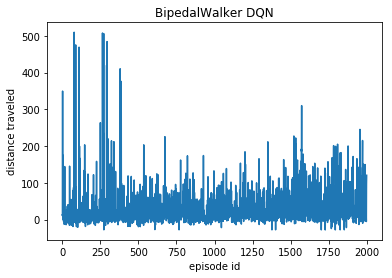

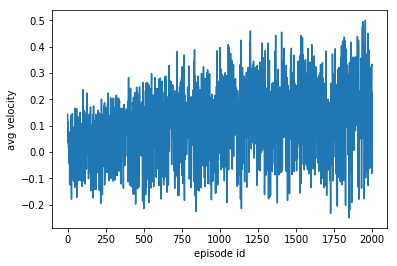

In [5]:
plt.title("BipedalWalker DQN")
plt.ylabel("distance traveled")
plt.xlabel("episode id")
plt.plot(np.arange(0, NUM_EPISODES, 1), distance_his)
plt.show()

plt.ylabel("avg velocity")
plt.xlabel("episode id")
plt.plot(np.arange(0, NUM_EPISODES, 1), velocity_his)
plt.show()